In [18]:
from outils import *
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
#import pydot_ng as pydot
#import matplotlib.pyplot as plt 
import gensim
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import keras
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional, GRU
from keras.models import Sequential
from keras.metrics import binary_accuracy
from keras.callbacks import *
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.layers import Flatten
from keras.callbacks import *
from keras.utils import plot_model  
from keras.models import load_model
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import pickle
import os
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
import numpy as np
from keras.optimizers import SGD, Adam,Adagrad , RMSprop,Adadelta,Adamax,Nadam,TFOptimizer

In [2]:
x_train, y_train, x_test, y_test = load_data()

In [3]:
x_test = x_test.reshape(72000)
x_train = x_train.reshape(168000)
np.place(y_train, y_train=='male', 1)
np.place(y_train, y_train=='female', 0)
np.place(y_test, y_test=='male', 1)
np.place(y_test, y_test=='female',0 )
y_test = y_test.reshape(72000)
y_train = y_train.reshape(168000)

In [4]:
#(train, test, word_index) = prepare_tokenized((x_train,x_test), 100000, 35)

In [5]:
print(len(y_train))
print(len(y_test))

168000
72000


In [6]:
max_num_words = 100000
max_sequence_length = 30
print('Tokenizing texts')
x_train, x_test, word_index = prepare_tokenized_data((x_train, x_test), max_num_words, max_sequence_length)
print('Finished tokenizing texts')

Tokenizing texts
Loaded tokenizer.pkl
Found 144388 unique 1-gram tokens.
Min sequence length: 0
Average sequence length: 9
Max sequence length: 60
Finished tokenizing texts


In [11]:
def loa_embedding_matrix(embedding_path, word_index, embedding_dim,gensim=True):
    if not os.path.exists('data/embedding_matrix.npy'):
        print('Load embedding model.')
        if gensim:
            word2vec = KeyedVectors.load(embedding_path)
            word2vec = word2vec.wv
        else:
            
            word2vec = KeyedVectors.load_word2vec_format(embedding_path)
        embeddings_index = {}
        for i in range(len(word2vec.index2word)):
            word = word2vec.index2word[i]
            vector = word2vec.index2word[i]
            embeddings_index[word] = word2vec[vector]
        print('Numbers of words in embedding model :', len(embeddings_index))
        print('Preparing embedding matrix.')
        embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        print('Embeding matrix size :', len(embedding_matrix))
        np.save('data/embedding_matrix.npy', embedding_matrix)
        print('Saved embedding matrix')
    else:
        embedding_matrix = np.load('data/embedding_matrix.npy')
        print('Loaded embedding matrix')
    return embedding_matrix

In [7]:
embedding_dim = 300
embedding_path = './data/embeddings/corpus_size=300_min_count=5_iter=10_sg=1_window=3'

In [12]:
embedding_matrix = loa_embedding_matrix(embedding_path, word_index, embedding_dim,gensim=True)

Load embedding model.
Numbers of words in embedding model : 656211
Preparing embedding matrix.
Embeding matrix size : 144389
Saved embedding matrix


In [13]:
from keras import backend as K
K.clear_session()

In [19]:
optimizers = ['SGD()','Adam()','RMSprop()','Adagrad()','Adadelta()','Adamax()','Nadam()']

In [31]:
dflist= []
for opt in optimizers:
    print('Optimizer : ' , opt,'\n')
    K.clear_session()
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False))
    model.add(Bidirectional(LSTM(100,activation='linear')))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=eval(opt), metrics=['accuracy'])
    h =model.fit(x_train[:5000],y_train[:5000],batch_size=32,epochs=10,validation_data=(x_test[:5000],y_test[:5000]),verbose=1)
    
    #y_pred = model.predict_classes(x_test)
    #evaluate(y_test,y_pred)
    dflist.append(pd.DataFrame(h.history,index=h.epoch))

Optimizer :  SGD() 

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 26s 5ms/step - loss: 0.6708 - acc: 0.6238 - val_loss: 0.5200 - val_acc: 1.0000
Epoch 2/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6590 - acc: 0.6354 - val_loss: 0.4784 - val_acc: 1.0000
Epoch 3/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6559 - acc: 0.6354 - val_loss: 0.4525 - val_acc: 1.0000
Epoch 4/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6558 - acc: 0.6354 - val_loss: 0.4483 - val_acc: 1.0000
Epoch 5/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6554 - acc: 0.6354 - val_loss: 0.4482 - val_acc: 1.0000
Epoch 6/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6543 - acc: 0.6354 - val_loss: 0.4461 - val_acc: 1.0000
Epoch 7/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6533 - acc: 0.6354 - val_loss: 0.4483 - va

5000/5000 [==============================] - 25s 5ms/step - loss: 0.5812 - acc: 0.6988 - val_loss: 0.4472 - val_acc: 0.8576
Epoch 9/10
5000/5000 [==============================] - 25s 5ms/step - loss: 0.5676 - acc: 0.7060 - val_loss: 0.3694 - val_acc: 0.9176
Epoch 10/10
5000/5000 [==============================] - 53s 11ms/step - loss: 0.5545 - acc: 0.7260 - val_loss: 0.4060 - val_acc: 0.8808
Optimizer :  Nadam() 

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 26s 5ms/step - loss: 0.6850 - acc: 0.6356 - val_loss: 0.3919 - val_acc: 0.9970
Epoch 2/10
5000/5000 [==============================] - 24s 5ms/step - loss: 0.6344 - acc: 0.6486 - val_loss: 0.4277 - val_acc: 0.9558
Epoch 3/10
5000/5000 [==============================] - 25s 5ms/step - loss: 0.6218 - acc: 0.6720 - val_loss: 0.4423 - val_acc: 0.9198
Epoch 4/10
5000/5000 [==============================] - 25s 5ms/step - loss: 0.6019 - acc: 0.6858 - val_loss: 0.3657 - val_acc: 

Populating the interactive namespace from numpy and matplotlib


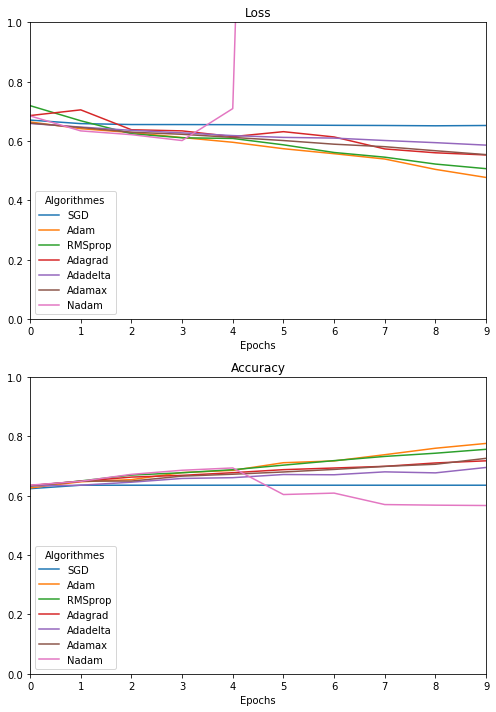

In [44]:
plot_histories(dflist)

In [65]:
def counts(array):
    y = np.bincount(array.astype(int))
    ii = np.nonzero(y)[0]
    print(np.vstack((ii,y[ii])).T)

In [51]:
def get_model():
    K.clear_session()
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False))
    model.add(Bidirectional(LSTM(150,activation='linear')))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [52]:
model = get_model()
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
x_train, y_train = randomize(x_train, y_train)
x_test, y_test = randomize(x_test, y_test)

In [54]:
history = model.fit(x_train,y_train,batch_size=100,epochs=10,validation_data=(x_test,y_test),verbose=1)

Train on 168000 samples, validate on 72000 samples
Epoch 1/2
168000/168000 [==============================] - 389s 2ms/step - loss: 0.6288 - acc: 0.6587 - val_loss: 0.6386 - val_acc: 0.6426
Epoch 2/2
168000/168000 [==============================] - 387s 2ms/step - loss: 0.6081 - acc: 0.6753 - val_loss: 0.6359 - val_acc: 0.6598


In [ ]:
def evaluate(model,file):
    sentences,genre = get_tweets(file)
    model.predict(tweets)

In [105]:
df = pd.read_csv('./data/test_data - Copie.csv',encoding='utf8')
df  = df[['id','genre']].copy()

In [106]:
with open('data/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
    print('Loaded tokenizer.pkl')
    
lables = []
predictions = []
i=0
for index, row in df.iterrows(): 
    print(i)
    i+=1

    if row.genre=='female':
        sentences,genre = get_tweets(row.id,0)
        lables.append(0)
    else:
        sentences,genre = get_tweets(row.id,1) 
        lables.append(1)

        
    sequences = tokenizer.texts_to_sequences(sentences)
    sentences = pad_sequences(sequences, maxlen=max_sequence_length)
    predictions.append(predict(model,sentences))


Loaded tokenizer.pkl
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


In [108]:
from sklearn.metrics import accuracy_score
accuracy_score(lables, predictions)

0.5106382978723404

In [ ]:
def tokenize(sentences,tokenizer):
    sequences = tokenizer.texts_to_sequences(sentences)
    sentences = pad_sequences(sequences, maxlen=max_sequence_length)

In [78]:
predict(model,tweets)

Found 144388 unique 1-gram tokens.
Min sequence length: 3
Average sequence length: 13
Max sequence length: 35


In [66]:
counts(y_test[:100])

[[ 0 63]
 [ 1 37]]


In [84]:
sentences_test

array([[   0,    0,    0, ..., 1130,  930, 1063],
       [   0,    0,    0, ...,    1, 1165, 1255],
       [   0,    0,    0, ...,   59,  786, 1054],
       ...,
       [   0,    0,    0, ...,    1, 1165, 1255],
       [   0,    0,    0, ...,  287,  614,  644],
       [   0,    0,    0, ...,  723,    3,   33]])

In [85]:
predict(model,sentences_test)

0

In [50]:
def randomize(dataset, labels):
    # Generate the permutation index array.
    permutation = np.random.permutation(dataset.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = dataset[permutation]
    shuffled_b = labels[permutation]
    return shuffled_a, shuffled_b

In [43]:
def plot_histories(dflist):
    historydf = pd.concat(dflist,axis=1)
    metrics_reported  =dflist[0].columns
    optimizers = ['SGD','Adam','RMSprop','Adagrad','Adadelta','Adamax','Nadam']
    idx = pd.MultiIndex.from_product([optimizers,metrics_reported],names=['Algorithmes','metric'])
    historydf.columns =idx
    %matplotlib inline
    %pylab inline
    pylab.rcParams['figure.figsize'] = (7, 10)
    ax = plt.subplot(211)
    historydf.xs('loss',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
    plt.title('Loss')
    plt.xlabel('Epochs')
    ax = plt.subplot(212)
    historydf.xs('acc',axis=1,level='metric').plot(ylim=(0,1),ax=ax)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.tight_layout()

In [ ]:
def get_tweets(file_name,genre):
    sentences = []
    with (open('./data/ar_PAN/{}.xml'.format(file_name),'r',encoding='utf8')) as f:
        doc = etree.parse(f)
    root = doc.getroot()
    for i in range(len(root[0])):
        sentences.append(preprocessing(root[0][i].text))
    return sentences,genre

In [ ]:
def predict(model,tweets):
    probability = model.predict_proba(tweets).mean()
    if probability > 0.5:
        return 1
    else:
        return 0

In [77]:
import pandas as pd
from lxml import etree
import os
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import pickle
import os
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
import numpy as np
from gensim.models import KeyedVectors